In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score,  confusion_matrix


## Predicting the Genre of Books from Summaries

We'll use a set of book summaries from the [CMU Book Summaries Corpus](http://www.cs.cmu.edu/~dbamman/booksummaries.html) in this experiment. This contains a large number of summaries (16,559) and includes meta-data about the genre of the books taken from Freebase.  Each book can have more than one genre and there are 227 genres listed in total.  To simplify the problem of genre prediction we will select a small number of target genres that occur frequently in the collection and select the books with these genre labels.  This will give us one genre label per book. 

In this project, we will build a predictive model to classify the books into one of the five target genres.

## Data Preparation

We read the data from our text file `booksummaries.txt`. It is made available in tab-separated format but has no column headings. We can use `read_csv` to read this but we need to set the separator to `\t` (tab) and supply the column names.  The names come from the [ReadMe](data/booksummaries/README.txt) file.

In [4]:
names = ['wid', 'fid', 'title', 'author', 'date', 'genres', 'summary']

books = pd.read_csv("booksummaries/booksummaries.txt", sep="\t", header=None, names=names, keep_default_na=False)
books.head()

,wid,fid,title,author,date,genres,summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,,,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


We next filter the data so that only our target genre labels are included and we assign each text to just one of the genre labels.  It's possible that one text could be labelled with two of these labels (eg. Science Fiction and Fantasy) but we will just assign one of those here. 

In [5]:
target_genres = ["Children's literature",
                 'Science Fiction',
                 'Novel',
                 'Fantasy',
                 'Mystery']

# create a Series of empty strings the same length as the list of books
genre = pd.Series(np.repeat("", books.shape[0]))
# look for each target genre and set the corresponding entries in the genre series to the genre label
for g in target_genres:
    genre[books['genres'].str.contains(g)] = g

# add this to the book dataframe and then select only those rows that have a genre label
# drop some useless columns
books['genre'] = genre
genre_books = books[genre!=''].drop(['genres', 'fid', 'wid'], axis=1)

genre_books.shape

(8954, 5)

In [6]:
# check how many books we have in each genre category
genre_books.groupby('genre').count()

,title,author,date,summary
genre,,,,
Children's literature,1092,1092,1092,1092
Fantasy,2311,2311,2311,2311
Mystery,1396,1396,1396,1396
Novel,2258,2258,2258,2258
Science Fiction,1897,1897,1897,1897


## Data Cleaning

In [7]:
genre_books.head()

,title,author,date,summary,genre
0,Animal Farm,George Orwell,1945-08-17,"Old Major, the old boar on the Manor Farm, ca...",Children's literature
1,A Clockwork Orange,Anthony Burgess,1962,"Alex, a teenager living in near-future Englan...",Novel
2,The Plague,Albert Camus,1947,The text of The Plague is divided into five p...,Novel
4,A Fire Upon the Deep,Vernor Vinge,,The novel posits that space around the Milky ...,Fantasy
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,"Ged is a young boy on Gont, one of the larger...",Fantasy


We see that the summary column has stopwords, punctuations, backslash-apostrophe. So we clean the column by removing these unnecessary words and punctuations.

In [8]:
 def clean_text(summary): #function for text cleaning
    summary = re.sub("[^a-zA-Z]"," ",summary)   #remove punctuations and leave only alphabets
    summary = re.sub("\'", "", summary) #remove backslash-apostrophe 
    summary = ' '.join(summary.split())  #remove whitespaces from the words
    summary = summary.lower()  #convert text to lowercase
    return summary

def remove_stopwords(summary): #function to remove stopwords
    no_stopword_summary = [w for w in summary.split() if not w in stop_words]
    return ' '.join(no_stopword_summary)

In [9]:
#create a new column that has clean_summary column by applying above defined functions to the existing summary column
genre_books['clean_summary'] = genre_books['summary'].apply(lambda x: clean_text(x))
genre_books['clean_summary'] = genre_books['clean_summary'].apply(lambda x: remove_stopwords(x))
genre_books.head()

,title,author,date,summary,genre,clean_summary
0,Animal Farm,George Orwell,1945-08-17,"Old Major, the old boar on the Manor Farm, ca...",Children's literature,old major old boar manor farm calls animals fa...
1,A Clockwork Orange,Anthony Burgess,1962,"Alex, a teenager living in near-future Englan...",Novel,alex teenager living near future england leads...
2,The Plague,Albert Camus,1947,The text of The Plague is divided into five p...,Novel,text plague divided five parts town oran thous...
4,A Fire Upon the Deep,Vernor Vinge,,The novel posits that space around the Milky ...,Fantasy,novel posits space around milky way divided co...
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,"Ged is a young boy on Gont, one of the larger...",Fantasy,ged young boy gont one larger islands north ar...


Now we have a new column 'clean_summary' which contains summary in all lower case without stopwords and punctuations.

## Modelling

We use logistic regression to build a model to predict the genre of book from summary.

Clean_summary column will act as a feature for our model. So, we extract feature from this text column using TfidfVectorizer from sklearn.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.8)
featurized_clean_summary = vectorizer.fit_transform(genre_books['clean_summary']) #featurizing the summary with tfidf vectorizing 

We next split our features into train and test data. For this, we use train_test_split method from sklearn.

In [11]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(featurized_clean_summary, genre_books['genre'], test_size=0.2)

In [13]:
model = LogisticRegression() #create an instance of LogisticRegression from sklearn

# fit model on train data
model.fit(xtrain, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
y_predicted_test = model.predict(xtest) #predict genre for summaries in xtest

print("Accuracy score for test data:",accuracy_score(y_predicted_test, ytest)) #compute accuracy score

Accuracy score for test data: 0.7079843662758235


In [15]:
y_predicted_train = model.predict(xtrain) #predict genre for summaries in xtrain
print("Accuracy score for train data:",accuracy_score(ytrain, y_predicted_train))  #compute accuracy score

Accuracy score for train data: 0.8775652659500209


The accuracy score for test data is 0.7 while for train data, its 0.877. We can interpret that if we use this model to predict in any unseen data, the model predicts the genre correctly approximately 70% of the time. The accuracy score for test and train data are close enough. This means the model we generateed is not overfitting and is good to use in unseen data.

In [34]:
cm = confusion_matrix(ytest, y_predicted_test) #confusion matrix
print("Confusion matrix-test data: \n",cm) #generate confusion matrix for test data 

Confusion matrix-test data: 
 [[ 64  56   8  66   2]
 [ 13 370   4  38  38]
 [  6  19 179  71   9]
 [ 11  26  11 367  38]
 [  7  43   7  50 288]]


In [36]:
print("\n",set(genre_books['genre'])) #checking genres


 {'Fantasy', "Children's literature", 'Novel', 'Mystery', 'Science Fiction'}


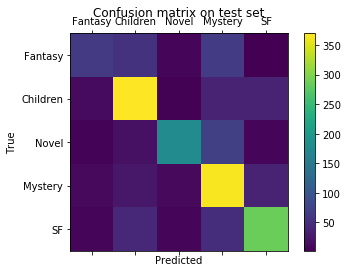

In [37]:
labels = ['Fantasy', "Children", 'Novel', 'Mystery', 'SF']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix on test set')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

From the confusion matrix, we can infer that out of 101 books with Fantasy genre, our model predicted 64 of them correctly. Similarly, out of 514 Literature's Children books, our model predicted 370 correctly. Out of 209 Novel 179 were predicted accurately. Likewise, from a total of 592 Mystery, 367 were predicted correctly, whereas, out of Science Fiction books, 288 were predicted accurately. 


## Thank You!